# importing libraries....

In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
import warnings
import random
import tensorflow_hub as hub
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from tensorflow.keras import layers
from keras.utils import to_categorical

In [2]:
# check for GPU...
print(f"TensorFlow has access to following devices : ")
for device in tf.config.list_physical_devices():
    print(f". {device}")

TensorFlow has access to following devices : 
. PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
. PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# filter warnings...
warnings.filterwarnings("ignore")

# EDA

In [4]:
# getting the data
train = pd.read_csv("tweet-sentiment-extraction/train.csv")
test = pd.read_csv("tweet-sentiment-extraction/test.csv")
sub = pd.read_csv("tweet-sentiment-extraction/sample_submission.csv")
# train data head....
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
# test data head....
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [6]:
# submissive data...
sub.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [7]:
# train data shape
train.shape

(27481, 4)

In [8]:
# data info....
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
# looking for null values...
train.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [10]:
# as there is onyl single null value in training set, so it's better to drop it...
train.dropna(inplace=True)

In [11]:
# looking for null value in test set..
test.isna().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [12]:
# target label distribution....
sentiment = train["sentiment"].value_counts()
sentiment

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [13]:
# setting the plot style...
plt.style.use("ggplot")

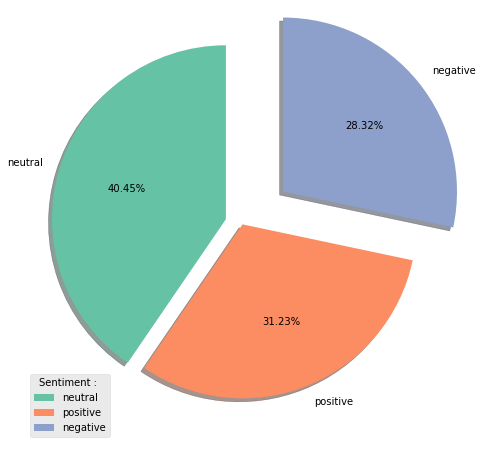

In [14]:
# plot the sentiment distribution...
plt.figure(figsize=(10,8))
labels = sentiment.index
colors = sns.color_palette("Set2")
explode = [0.1,0,0.3]
plt.pie(sentiment,labels = labels, colors = colors, explode = explode,
       autopct = "%.2f%%", startangle = 90, shadow = True)
plt.legend(title = "Sentiment : ")
plt.show()

In [15]:
# test data target label distribution
test_sentiment = test.sentiment.value_counts()
test_sentiment

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

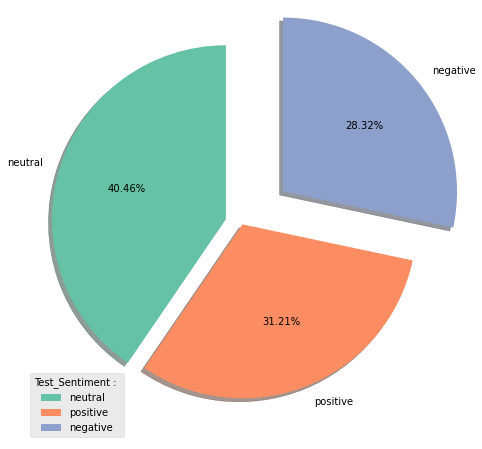

In [16]:
# plot the sentiment distribution...
plt.figure(figsize=(10,8))
labels = test_sentiment.index
colors = sns.color_palette("Set2")
explode = [0.1,0,0.3]
plt.pie(test_sentiment,labels = labels, colors = colors, explode = explode,
       autopct = "%.2f%%", startangle = 90, shadow = True)
plt.legend(title = "Test_Sentiment : ")
plt.show()

In [17]:
# changing the data-type...
train["text"] =  train["text"].astype("string")

In [18]:
# checking the length of the selected text...
train["length"] = train["text"].apply(lambda x: len(x.split()))
train.head()

,textID,text,selected_text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14


In [19]:
# checking the length of test text data
test["length"] = test["text"].apply(lambda x: len(x.split()))
test

,textID,text,sentiment,length
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,6
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,15
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,13
3,01082688c6,happy bday!,positive,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,5
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,15
3530,416863ce47,All alone in this old house again. Thanks for...,positive,26
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,18
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,14


In [20]:
print(f"Max length of tweet text in training set : {train['length'].max()}")
print(f"Min lenght of tweet text in training set. : {train['length'].min()}")
print(f"Max length of tweet text in test set : {test['length'].max()}")
print(f"Min lenght of tweet text in test set. : {test['length'].min()}")

Max length of tweet text in training set : 33
Min lenght of tweet text in training set. : 1
Max length of tweet text in test set : 32
Min lenght of tweet text in test set. : 1


In [21]:
print(f"Shortest tweets in training set : \n{train[train['length']==min(train['length'])]}")

Shortest tweets in training set : 
           textID           text selected_text sentiment  length
42     2e7082d1c8       MAYDAY?!      MAYDAY?!   neutral       1
68     fa2654e730       Chilliin      Chilliin  positive       1
127    8e1583cb08     Absolutely    Absolutely   neutral       1
224    f3a77c2b5e       _nesmith      _nesmith   neutral       1
238    e98226e842            Thx           Thx   neutral       1
...           ...            ...           ...       ...     ...
26690  e80c242d6a     Goodnight;    Goodnight;  positive       1
26693  7dc13f50d8   yessssssir!!  yessssssir!!   neutral       1
26726  aad244f37d          *hug*         *hug*  positive       1
26754  b6f6bd82c0       careless      careless  negative       1
26843  a46571fe12      congrats!     congrats!  positive       1

[199 rows x 5 columns]


In [22]:
print(f"longest tweets in training set : \n{train[train['length']==max(train['length'])]}")

longest tweets in training set : 
           textID                                               text  \
19887  ede80b9f63  AK, flop comes 2K6 I bet 15 get raised to 25 I...   
25359  be445111e7  : Lol it went okay! As far as I can tell . But...   

                                           selected_text sentiment  length  
19887  AK, flop comes 2K6 I bet 15 get raised to 25 I...   neutral      33  
25359                               Lol it went okay! As  positive      33  


<Figure size 720x576 with 0 Axes>

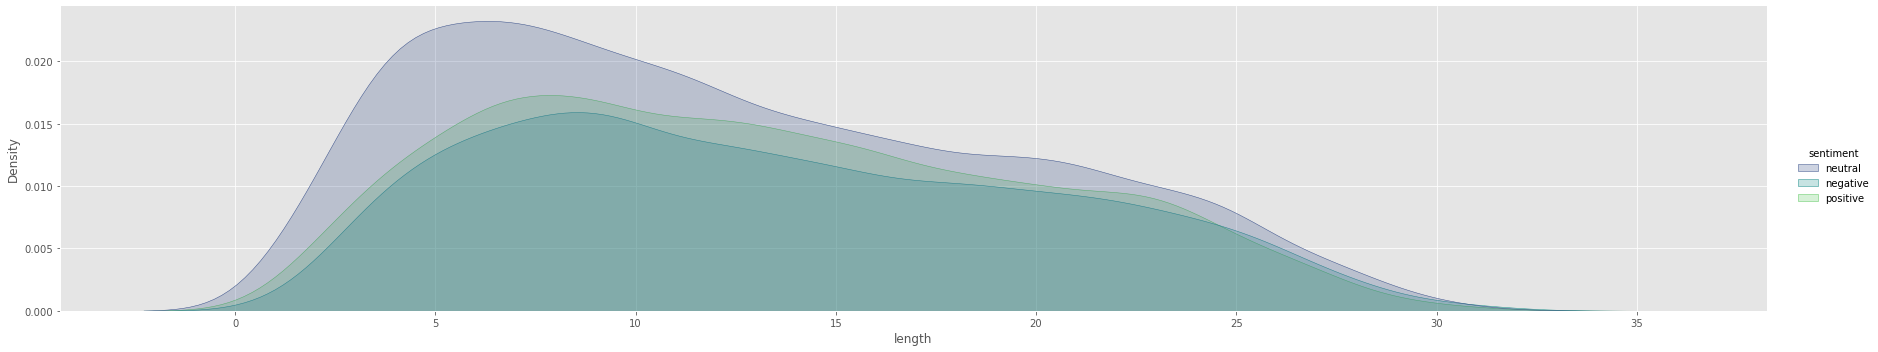

In [23]:
# plot the length of tweet text across the sentiment....
plt.figure(figsize=(10,8))
sns.displot(data = train, x = "length", hue = "sentiment",
           kind = "kde", fill = True, aspect = 5, palette = "viridis");

<Figure size 720x576 with 0 Axes>

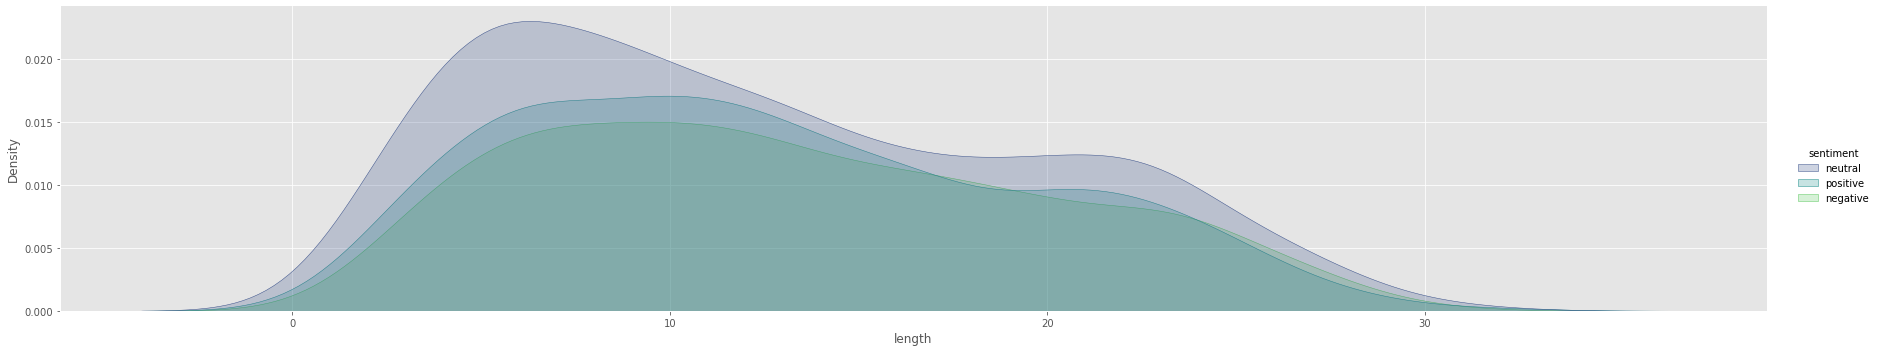

In [24]:
# plot the length of test tweet text across the sentiment....
plt.figure(figsize=(10,8))
sns.displot(data = test, x = "length", hue = "sentiment",
           kind = "kde", fill = True, aspect = 5, palette = "viridis");

In [25]:
# let's drop the selected_text column 
train.drop("selected_text",axis=1,inplace=True)

In [26]:
train.head(10)

,textID,text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,10
2,088c60f138,my boss is bullying me...,negative,5
3,9642c003ef,what interview! leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,14
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,neutral,12
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive,14
7,50e14c0bb8,Soooo high,neutral,2
8,e050245fbd,Both of you,neutral,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,positive,10


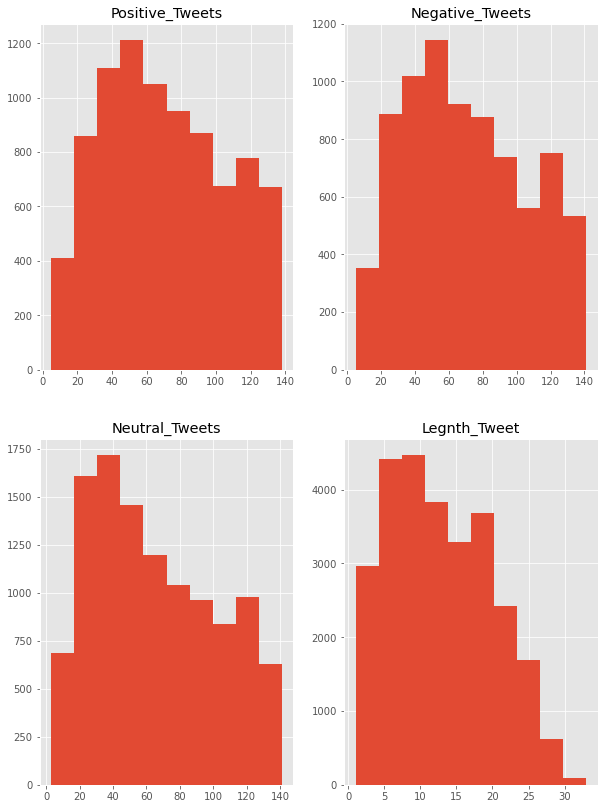

In [27]:
# plotting the number of characters in tweet per sentiment...

# positive tweet lenth
len_positive = train[train['sentiment']=="positive"]['text'].str.len()

# negative tweet length
len_negative = train[train["sentiment"]=="negative"]["text"].str.len()

# neutral tweet length
len_neutral = train[train["sentiment"]=="neutral"]["text"].str.len()

fig,ax = plt.subplots(2,2,figsize=(10,14))

# plotting positive tweet
ax[0,0].hist(len_positive)
ax[0,0].set_title("Positive_Tweets")

# plotting negative tweet
ax[0,1].hist(len_negative)
ax[0,1].set_title("Negative_Tweets")

# plotting positive tweet
ax[1,0].hist(len_neutral)
ax[1,0].set_title("Neutral_Tweets")

# plotting the overall length of tweets...
ax[1,1].hist(train["length"])
ax[1,1].set_title("Legnth_Tweet");

In [28]:
# now it's time to clean text, so let's make a function for it...
def clean_text(text):
    
    # convert text into lower
    text = str(text).lower()
    
    #     remove urls
    text = re.sub(r"https:\S+"," ",text)
    
    #     remove punctuation
    text = re.sub(r"[^\w\s]","",text)
    
    #     remove mentions
    text = re.sub(r'@\w+', " ", text)
    
    #     remove hashtags
    text = re.sub("#\w+"," ", text)
    
    #     remove digits
    text = re.sub(r"\d+"," ", text)
    
    #     remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
        
    return text 


In [29]:
# apply the function to train df
train["clean_text"] = train["text"].apply(lambda x : clean_text(x))

train.sample(10)

,textID,text,sentiment,length,clean_text
13649,dc154f8871,Too bad we`re in Sweden where Up isn`t up on ...,negative,15,too bad were in sweden where up isnt up on th...
3019,3ade80fe74,"may gray, coldplay, and nice showers...work at 2",positive,8,may gray coldplay and nice showerswork at
26673,80b87139ea,": Your mail server just rejected a simple, pla...",negative,18,your mail server just rejected a simple plain...
2653,2a580b779a,Happy mothers day mom.. i love yew...,positive,7,happy mothers day mom i love yew
4934,dae3b9f309,I couldn`t find P4 so I couldn`t show Brantley...,neutral,15,i couldnt find p so i couldnt show brantley m...
26956,a955fb8788,yes - it has put a damper on us 'getting to k...,neutral,25,yes it has put a damper on us getting to kno...
3624,c75ce3387f,Any city person want to trade n live in the co...,neutral,21,any city person want to trade n live in the co...
17815,771d1dbc22,which means i spend more time alone than with...,negative,14,which means i spend more time alone than with...
4999,375b64de34,Sooo tired and have a headache-all self inflic...,neutral,13,sooo tired and have a headacheall self inflict...
21037,c97ca19c1f,"Shite night, tomorow, I get to hang out with m...",positive,22,shite night tomorow i get to hang out with my ...


In [30]:
# apply it to test data as well
test["clean_text"] = test["text"].apply(lambda x : clean_text(x))

test.sample(10)

,textID,text,sentiment,length,clean_text
284,5be41389ce,I need botox work on the lips if I`m going to...,negative,26,i need botox work on the lips if im going to ...
697,0c79867978,My net died so yeah.... I`m sad now,negative,8,my net died so yeah im sad now
3239,47caebc343,headed to the beach with puppy maverick hugs a...,positive,11,headed to the beach with puppy maverick hugs a...
2651,0d63dff2e5,"you don`t even care about there, their, and t...",neutral,9,you dont even care about there their and theyre
2457,de20a4f9ba,What happened with her??? Why is she being so ...,negative,14,what happened with her why is she being so wie...
747,058f39acca,I want cookies for breakfast! Luckily I`m an a...,positive,13,i want cookies for breakfast luckily im an adu...
3505,f66bda14c6,ï¿½ï¿½We are ready for the new generation!!......,positive,18,ï½ï½we are ready for the new generationoh yeah...
1061,afa094db6a,got alot of runnin around to do today to get t...,positive,27,got alot of runnin around to do today to get t...
3357,ed58e3db1d,Bit disappointed with The Killers On Jonathan ...,negative,13,bit disappointed with the killers on jonathan ...
98,af63915fa9,I`m leaving work now. Trying to decide if I re...,neutral,24,im leaving work now trying to decide if i retu...


In [31]:
# setting stopwords
stop=set(stopwords.words('english'))

Text(0.5, 0.98, 'Common words in tweet text')

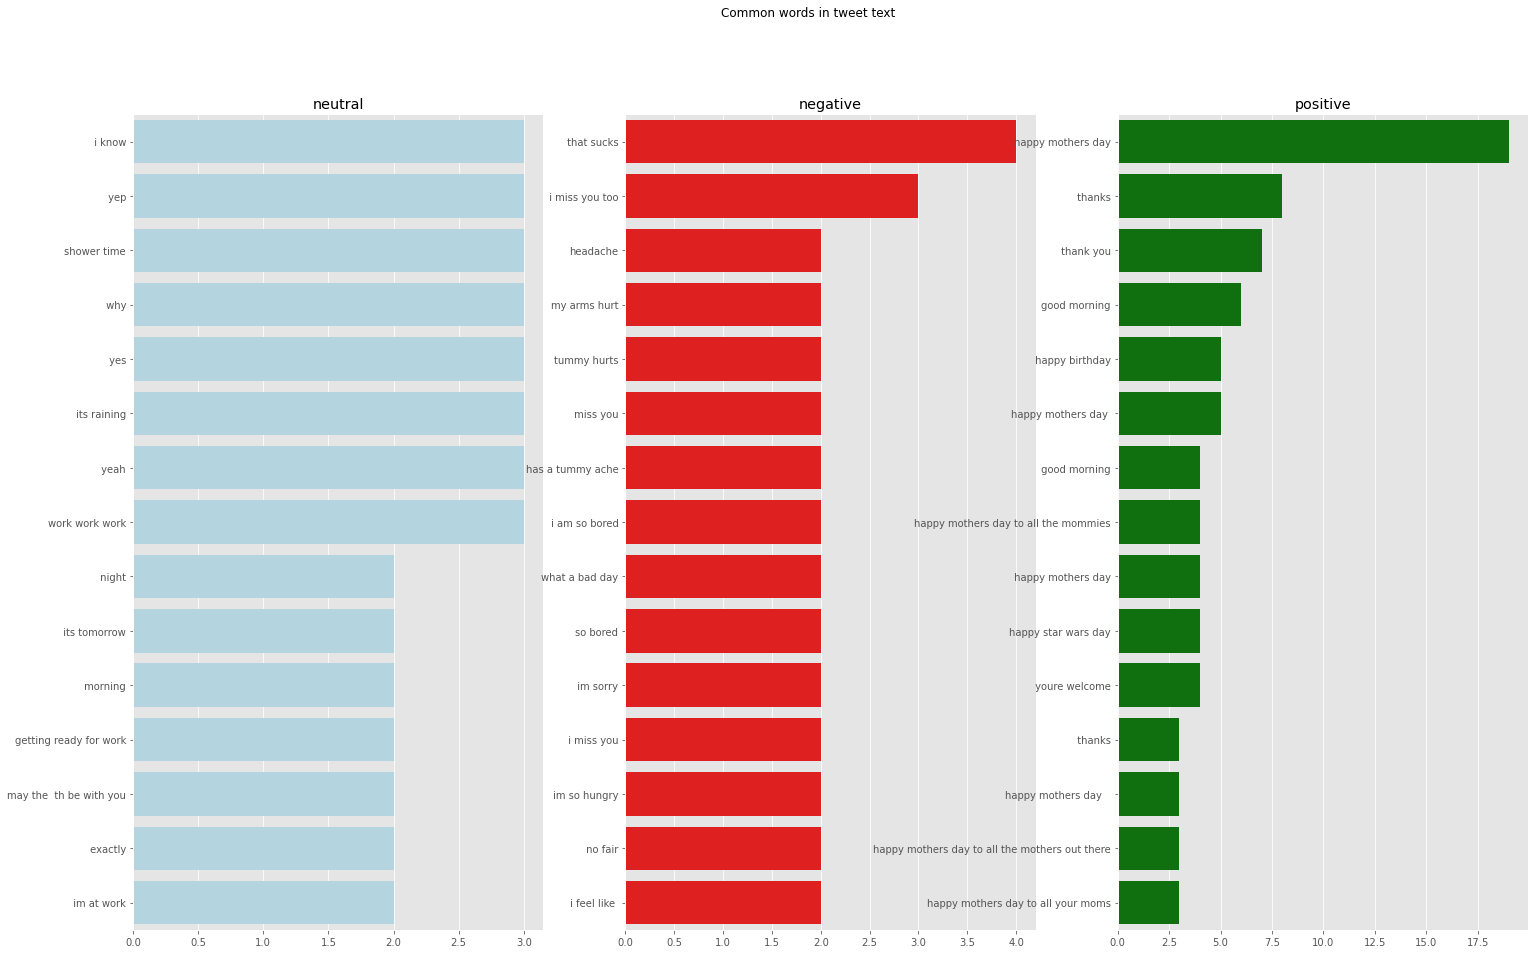

In [32]:
# let's find out the most common words in the text.....
sentiments = train["sentiment"].unique()

# setup the figure
fig,ax = plt.subplots(1,3, figsize=(25,15))
colors = ["lightblue","red","green",]
for i in range(3):
    new = train[train["sentiment"]==sentiments[i]]["clean_text"]
    counter = Counter(new)
    most_common = counter.most_common()
    x = []
    y = []
    
    for word,count in most_common[:15]:
        x.append(word)
        y.append(count)
        
    sns.barplot(x=y,y=x,ax=ax[i], color = colors[i])
    ax[i].set_title(sentiments[i])
fig.suptitle("Common words in tweet text")

In [33]:
# pick the main columns....
train_text = train["clean_text"]
train_labels = train["sentiment"]

test_text = test["clean_text"]
test_labels = test["sentiment"]

In [34]:
# as our label is in text so map it

l = {"neutral" : 0, "positive" : 1,"negative" : 2}

# apply it to the data....

train_labels = train_labels.map(l)
test_labels = test_labels.map(l)

In [35]:
train_text

0                        id have responded if i were going
1               sooo sad i will miss you here in san diego
2                                   my boss is bullying me
3                            what interview leave me alone
4         sons of  why couldnt they put them on the rel...
                               ...                        
27476     wish we could come see u on denver  husband l...
27477     ive wondered about rake to  the client has ma...
27478     yay good for both of you enjoy the break  you...
27479                                but it was worth it  
27480       all this flirting going on  the atg smiles ...
Name: clean_text, Length: 27480, dtype: object

# Tokenization : 
    As we clean our text let's split the data and convert each split into integer through tokenization because our deep learning models works only with the numbers....



In [36]:
# find the average length of sentence...
round(np.mean(train["length"]))

13

In [37]:
# setup the vocabulary length...
max_token = 15000
max_len = 15


token = TextVectorization(max_tokens = max_token,
                         standardize = "lower_and_strip_punctuation",
                         output_mode = "int",
                         output_sequence_length = max_len,
                         split = "whitespace")

# adapt to text
token.adapt(train_text)

Metal device set to: Apple M1


2022-10-18 22:03:52.338551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-18 22:03:52.338926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-18 22:03:52.384157: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-18 22:03:52.441491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [38]:
# get some text information....
vocab = token.get_vocabulary()
print(f"Total words in the Vocabulary : {len(vocab)}")
print(f"Top five words in the Vocabulary : {vocab[:5]}")
print(f"Bottom five words in the Vocabulary : {vocab[-5:]}")

Total words in the Vocabulary : 15000
Top five words in the Vocabulary : ['', '[UNK]', 'i', 'to', 'the']
Bottom five words in the Vocabulary : ['rightards', 'rigby', 'rig', 'rieger', 'ridin']


In [39]:
# let's tokenize some sentence....
random_index = np.random.randint(0,len(train_text))
random_sentence = train_text[random_index]

print(f"Original Text : {random_sentence}\n")
print(f"Tokenize Sentence : {token([random_sentence])}")

Original Text : head in the clouds

Tokenize Sentence : [[ 309   11    4 2503    0    0    0    0    0    0    0    0    0    0
     0]]


# Embedding
   
  A word embedding is a class of approaches for representing words and documents using a dense vector representation. Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn

In [40]:
embedd = Embedding(input_dim = max_token,
                  output_dim = 256,
                   input_length = max_len,
                   embeddings_initializer = "uniform",
                  )

In [41]:
# let's tokenize and embedd some sentence....
random_index = np.random.randint(0,len(train_text))
random_sentence = train_text[random_index]

print(f"Original Text : {random_sentence}\n")
print(f"Tokenize Sentence : {token([random_sentence])}\n")
print(f"Tokenize Sentence : {embedd(token([random_sentence]))}")

Original Text :  ok im off to pc world then   tweet u later  lol

Tokenize Sentence : [[ 172   14   86    3 1094  272  103  271   56  274   53    0    0    0
     0]]

Tokenize Sentence : [[[ 0.02996316  0.03638244  0.00858381 ...  0.00816146 -0.04721428
    0.0409237 ]
  [ 0.02683884 -0.03508665  0.03076566 ... -0.00702082  0.03329351
   -0.0268344 ]
  [-0.03217454 -0.04577069  0.01918976 ... -0.01406696  0.02367904
    0.00152643]
  ...
  [ 0.01755545 -0.01867199 -0.00228287 ... -0.0406209  -0.03763139
   -0.01541952]
  [ 0.01755545 -0.01867199 -0.00228287 ... -0.0406209  -0.03763139
   -0.01541952]
  [ 0.01755545 -0.01867199 -0.00228287 ... -0.0406209  -0.03763139
   -0.01541952]]]


In [42]:
# let's make a function to evaluate our model performance....
def calculate_results(y_true,y_pred):
    """
    This function will evaluate our model performace by measuring certain metrics....
    Accuracy : it tells us that how accurately our model predict the label
    Precision : this is the ability of classifier not to label a negative label as positive.
    Recall : this is the ability of classifier to find all positive labels.
    Fscore : this is the average of preicision and recall.
    """
    accuracy = accuracy_score(y_true,y_pred)
    precision_score,recall_score,f_score,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    
    results = {
        "Accuracy" : accuracy ,
        "Precision" : precision_score,
        "Recall" : recall_score,
        "F_Score" : f_score
    }
    return results

# Modelling : 
     
     We'll build a series of model and pick the one that performs better.
    ~Naive Model
    ~Dense Model
    ~LSTM Model
    ~GRU Model
    ~Bidirectional Model
    ~Conv1D Model
    ~Transfer Learning Model

# Model_0 : Naive Model

In [43]:
# let's build our first sklearn naive model...
model_0 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ("naive",MultinomialNB())
])

# fitting model to data....
model_0.fit(train_text,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('naive', MultinomialNB())])

In [44]:
# calculate model results....
model_0_results = calculate_results(test_labels,model_0.predict(test_text))
model_0_results

{'Accuracy': 0.620826259196378,
 'Precision': 0.6920038667463424,
 'Recall': 0.620826259196378,
 'F_Score': 0.6084458841291476}

In [45]:
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels,3)


# Model 2 : Simple Dense Model

In [46]:
# let's build our first dense model.....

# set up the random seed....
tf.random.set_seed(42)

# define the inputs....
inputs = layers.Input(shape=(),dtype="string")

# pass inputs to tokenization layer....
x = token(inputs)

# pass the token to embeddings....
x = embedd(x)

# hidden layers...
x = layers.Dense(64,activation="relu")(x)

# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the globalaverage layer...
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_1 = tf.keras.Model(inputs,output,name="Dense_Model")

# compiling the model...
model_1.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [47]:
# model summary.....
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense (Dense)               (None, 15, 64)            16448     
                                                                 
 dense_1 (Dense)             (None, 15, 32)            2080      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                

In [48]:
# fitting the model to data....
history_1 = model_1.fit(train_text,train_labels,
                       epochs=10,
                       validation_data=(test_text,test_labels),
                        validation_split = int(len(test_text) * 0.25),
                        callbacks = [tf.keras.callbacks.ModelCheckpoint("Dense_1.tf",
                                                                               save_best_only=True)])

Epoch 1/10


2022-10-18 22:03:53.755155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.8479 - accuracy: 0.6131

2022-10-18 22:04:10.875114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: Dense_1.tf/assets
859/859 [==============================] - 19s 22ms/step - loss: 0.8479 - accuracy: 0.6131 - val_loss: 0.7523 - val_accuracy: 0.6882
Epoch 2/10
859/859 [==============================] - 18s 21ms/step - loss: 0.7027 - accuracy: 0.7131 - val_loss: 0.7341 - val_accuracy: 0.6853
Epoch 3/10
859/859 [==============================] - 18s 20ms/step - loss: 0.6456 - accuracy: 0.7460 - val_loss: 0.7350 - val_accuracy: 0.6913
Epoch 4/10
859/859 [==============================] - 17s 20ms/step - loss: 0.6021 - accuracy: 0.7693 - val_loss: 0.7540 - val_accuracy: 0.6870
Epoch 5/10
859/859 [==============================] - 17s 20ms/step - loss: 0.5682 - accuracy: 0.7841 - val_loss: 0.7805 - val_accuracy: 0.6814
Epoch 6/10
859/859 [==============================] - 17s 20ms/step - loss: 0.5452 - accuracy: 0.7974 - val_loss: 0.7937 - val_accuracy: 0.6783
Epoch 7/10
859/859 [==============================] - 18s 20ms/step - loss: 0.5245 - accuracy:

In [49]:
os.listdir("Dense_1.tf")

['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']

In [50]:
# let's load the best model...
model_1 = tf.keras.models.load_model("Dense_1.tf")

2022-10-18 22:06:51.482545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:06:51.487597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [51]:
# make predictions and calculate the results...
model_1_results = calculate_results(test_labels,tf.squeeze(tf.round(model_1.predict(test_text))))
model_1_results

 13/111 [==>...........................] - ETA: 0s

2022-10-18 22:06:51.597212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 1s 4ms/step


{'Accuracy': 0.6508205998868138,
 'Precision': 0.7372513024313728,
 'Recall': 0.6508205998868138,
 'F_Score': 0.6756128686511008}

In [52]:
# let's make a function that will plot the model performance......
def plot_model_performance(history):
    
    loss = history.history["loss"]
    
    val_loss = history.history["val_loss"]
    
    acc = history.history["accuracy"]
    
    val_acc = history.history["val_accuracy"]
    
    epochs = range(len(loss))
    
    
#     plottint the model accuracy vs validation accuracy
    plt.plot(epochs,acc,label="Training Accuracy",marker = "*",linestyle = "dotted")
    plt.plot(epochs,val_acc,label="Validation Accuracy",marker = "P", linestyle = "dashed")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.legend(title="Accuracy")
    
    
#     plotting the training vs validation loss
    plt.figure()
    plt.plot(epochs,loss,label="Training Loss",marker="1", linestyle = "dotted")
    plt.plot(epochs,val_loss,label="Validation Loss",marker = "2", linestyle = "dashed")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.legend(title="Loss")
    plt.show()

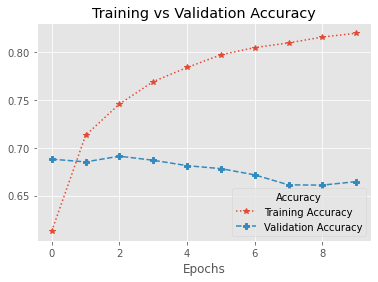

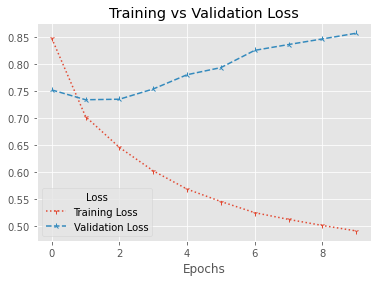

In [53]:
# plot the model performance...
plot_model_performance(history_1)

# Model 2 : LSTM

In [54]:
# let's build the 3rd Model LSTM (Long-Short-Term-Memory)

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)
# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the lstm layer
x = layers.LSTM(64,return_sequences=True)(x)

# adding the drop-out layer...
x = layers.Dropout(0.1)(x)

# LSTM layer
x = layers.LSTM(32,)(x)

# output layer....
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_2 = tf.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_2.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [55]:
# model summary....
model_2.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense_3 (Dense)             (None, 15, 64)            16448     
                                                                 
 dense_4 (Dense)             (None, 15, 32)            2080      
                                                                 
 lstm (LSTM)                 (None, 15, 64)            24832     
                                                        

In [56]:
# fitting the model to data....
history_2 = model_2.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.25),
                        callbacks = [tf.keras.callbacks.ModelCheckpoint("LSTM.tf",
                                                                               save_best_only=True)])

Epoch 1/10


2022-10-18 22:06:53.937061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:06:54.188429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:06:54.271405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:06:54.338919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/859 [..............................] - ETA: 28:58 - loss: 1.0988 - accuracy: 0.3750

2022-10-18 22:06:54.463872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.5682 - accuracy: 0.7764

2022-10-18 22:07:23.337009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:07:23.436601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:07:23.484018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: LSTM.tf/assets


INFO:tensorflow:Assets written to: LSTM.tf/assets


859/859 [==============================] - 39s 43ms/step - loss: 0.5682 - accuracy: 0.7764 - val_loss: 0.7989 - val_accuracy: 0.6587
Epoch 2/10
859/859 [==============================] - 29s 33ms/step - loss: 0.4843 - accuracy: 0.8154 - val_loss: 0.8160 - val_accuracy: 0.6587
Epoch 3/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4542 - accuracy: 0.8297 - val_loss: 0.8357 - val_accuracy: 0.6610
Epoch 4/10
859/859 [==============================] - 30s 34ms/step - loss: 0.4353 - accuracy: 0.8353 - val_loss: 0.8548 - val_accuracy: 0.6647
Epoch 5/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4208 - accuracy: 0.8425 - val_loss: 0.8452 - val_accuracy: 0.6647
Epoch 6/10
859/859 [==============================] - 30s 34ms/step - loss: 0.4090 - accuracy: 0.8479 - val_loss: 0.8364 - val_accuracy: 0.6692
Epoch 7/10
859/859 [==============================] - 31s 36ms/step - loss: 0.3974 - accuracy: 0.8508 - val_loss: 0.8962 - val_accuracy: 0.6576
Epo

In [57]:
# let's load the best model...
model_2 = tf.keras.models.load_model("LSTM.tf")

2022-10-18 22:12:04.816953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:12:04.821742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [58]:
# make prediction and calculate results....
model_2_results = calculate_results(test_labels, tf.squeeze(tf.round(model_2.predict(test_text))))
model_2_results

  1/111 [..............................] - ETA: 50s

2022-10-18 22:12:05.370225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:12:05.466251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:12:05.515323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 1s 9ms/step


{'Accuracy': 0.6301641199773628,
 'Precision': 0.6771799833344927,
 'Recall': 0.6301641199773628,
 'F_Score': 0.6527262065548162}

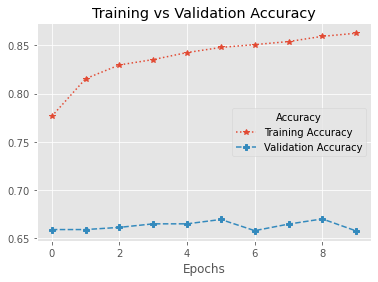

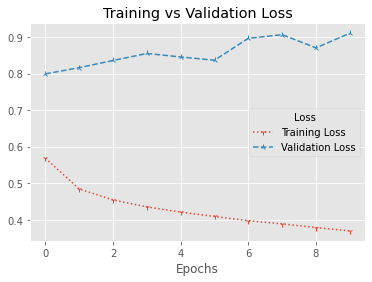

In [59]:
# plot model performance...
plot_model_performance(history_2)

# Model 3 : GRU

In [60]:
# let's build the Model GRU(Gated Recurrent Units)

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)

# adding drop-out layer....
x = layers.Dropout(0.1)(x)

# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)

# adding the lstm layer
x = layers.GRU(64,return_sequences=True)(x)

# adding the drop-out layer...
x = layers.Dropout(0.1)(x)

# LSTM layer
x = layers.GRU(32,)(x)

# output layer....
output = layers.Dense(3,activation="sigmoid")(x)

# model building....
model_3 = tf.keras.Model(inputs,output,name="GRU_Model")

# compiling the model...
model_3.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [61]:
# model summary...
model_3.summary()

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense_6 (Dense)             (None, 15, 64)            16448     
                                                                 
 dropout_1 (Dropout)         (None, 15, 64)            0         
                                                                 
 dense_7 (Dense)             (None, 15, 32)            2080      
                                                         

In [62]:
# fitting the model to data....
history_3 = model_3.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.30),
                       callbacks = [tf.keras.callbacks.ModelCheckpoint("GRU.tf",
                                                                               save_best_only=True)])

Epoch 1/10


2022-10-18 22:12:08.329542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:12:08.601695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:12:08.668698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:12:08.754530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/859 [..............................] - ETA: 27:28 - loss: 1.0857 - accuracy: 0.4375

2022-10-18 22:12:08.863432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.7393

2022-10-18 22:12:40.317396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:12:40.415058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:12:40.458398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: GRU.tf/assets


INFO:tensorflow:Assets written to: GRU.tf/assets


859/859 [==============================] - 41s 46ms/step - loss: 0.6456 - accuracy: 0.7393 - val_loss: 0.7893 - val_accuracy: 0.6689
Epoch 2/10
859/859 [==============================] - 32s 37ms/step - loss: 0.5742 - accuracy: 0.7785 - val_loss: 0.8291 - val_accuracy: 0.6726
Epoch 3/10
859/859 [==============================] - 31s 36ms/step - loss: 0.6262 - accuracy: 0.7482 - val_loss: 0.9149 - val_accuracy: 0.5903
Epoch 4/10
859/859 [==============================] - 31s 36ms/step - loss: 0.6851 - accuracy: 0.7099 - val_loss: 0.8832 - val_accuracy: 0.6092
Epoch 5/10
859/859 [==============================] - 33s 38ms/step - loss: 0.6443 - accuracy: 0.7316 - val_loss: 0.8651 - val_accuracy: 0.6242
Epoch 6/10
859/859 [==============================] - 32s 38ms/step - loss: 0.6176 - accuracy: 0.7453 - val_loss: 0.8768 - val_accuracy: 0.6225
Epoch 7/10
859/859 [==============================] - 32s 37ms/step - loss: 0.6044 - accuracy: 0.7575 - val_loss: 0.8999 - val_accuracy: 0.6299
Epo

In [63]:
# let's load the best model...
model_3 = tf.keras.models.load_model("GRU.tf")

2022-10-18 22:17:39.148794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:39.153755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [64]:
# make prediction and calculate results....
model_3_results = calculate_results(test_labels, tf.squeeze(tf.round(model_3.predict(test_text))))
model_3_results

  1/111 [..............................] - ETA: 47s

2022-10-18 22:17:39.649115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:39.736085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:39.782372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 1s 9ms/step


{'Accuracy': 0.3678551216751556,
 'Precision': 0.5441936008569953,
 'Recall': 0.8248443689869835,
 'F_Score': 0.6548214791244519}

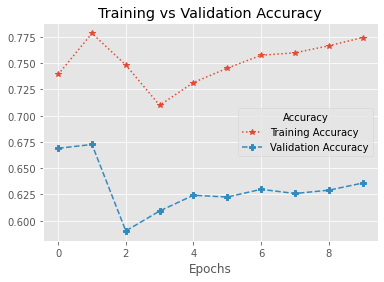

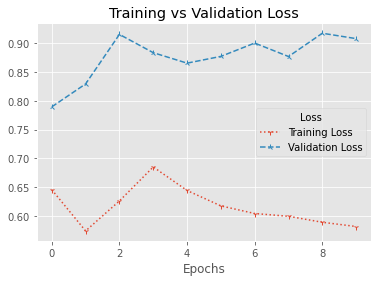

In [65]:
# plot model performance....
plot_model_performance(history_3)

# Model 4 : BiDirectional 

In [66]:
# let's build the BiDirectional Model....

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# adding the Bidirectional layer
x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)

# Bidirectional layer
x = layers.Bidirectional(layers.LSTM(32,))(x)

# output layer....
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_4 = tf.keras.Model(inputs,output,name="Bidirectional_Model")

# compiling the model...
model_4.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [67]:
# model summary....
model_4.summary()

Model: "Bidirectional_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          164352    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                               

In [68]:
# fitting model to data...
history_4 = model_4.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.30),
                       callbacks = [tf.keras.callbacks.ModelCheckpoint("Bidirect.tf",save_best_only=True)])

Epoch 1/10


2022-10-18 22:17:43.982494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:44.355460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:44.379356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:44.469477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:44.479531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:44.590428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:17:44.610817: I tensorflow/core/grappler/optimizers/cust

859/859 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.8016

2022-10-18 22:18:24.744990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:18:24.876424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:18:24.883602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:18:24.994022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:18:25.001542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: Bidirect.tf/assets


INFO:tensorflow:Assets written to: Bidirect.tf/assets


859/859 [==============================] - 66s 73ms/step - loss: 0.5160 - accuracy: 0.8016 - val_loss: 0.8355 - val_accuracy: 0.6667
Epoch 2/10
859/859 [==============================] - 40s 46ms/step - loss: 0.4391 - accuracy: 0.8366 - val_loss: 0.8453 - val_accuracy: 0.6636
Epoch 3/10
859/859 [==============================] - 40s 47ms/step - loss: 0.4033 - accuracy: 0.8517 - val_loss: 0.8483 - val_accuracy: 0.6701
Epoch 4/10
859/859 [==============================] - 39s 46ms/step - loss: 0.3742 - accuracy: 0.8629 - val_loss: 0.9076 - val_accuracy: 0.6743
Epoch 5/10
859/859 [==============================] - 39s 46ms/step - loss: 0.3464 - accuracy: 0.8727 - val_loss: 0.9034 - val_accuracy: 0.6701
Epoch 6/10
859/859 [==============================] - 39s 46ms/step - loss: 0.3170 - accuracy: 0.8838 - val_loss: 0.9388 - val_accuracy: 0.6669
Epoch 7/10
859/859 [==============================] - 39s 46ms/step - loss: 0.2820 - accuracy: 0.8985 - val_loss: 0.9860 - val_accuracy: 0.6689
Epo

In [69]:
# let's load the best model... 
model_4 = tf.keras.models.load_model("Bidirect.tf")

2022-10-18 22:25:03.384173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:25:03.389679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [70]:
# make predictions and calculate results....
model_4_results = calculate_results(test_labels,tf.squeeze(tf.round(model_4.predict(test_text))))
model_4_results

2022-10-18 22:25:04.406591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:25:04.546460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:25:04.553608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/111 [..............................] - ETA: 3s  

2022-10-18 22:25:04.666493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:25:04.674155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 3s 15ms/step


{'Accuracy': 0.6397849462365591,
 'Precision': 0.6812844525898056,
 'Recall': 0.6397849462365591,
 'F_Score': 0.6597545733447184}

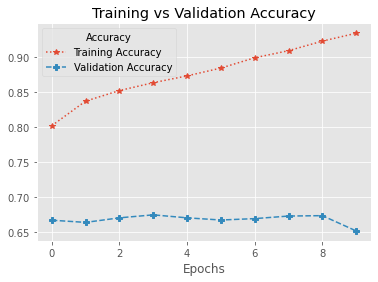

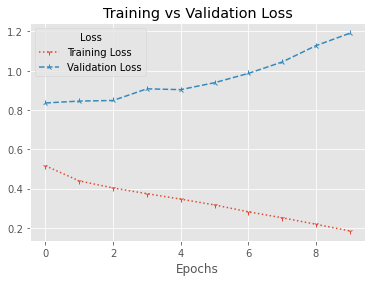

In [71]:
# plot model performance....
plot_model_performance(history_4)

# Model 5 : Conv1D

In [72]:
# as our previous models are overfitting to data....
# let's build another model Conv1D

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# adding the Conv1D layer...
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = "relu")(x)

# adding the MaxPool1D layer....
x = layers.GlobalMaxPool1D()(x)

# output layer....
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_5 = tf.keras.Model(inputs,output,name="Conv1D_Model")

# compiling the model...
model_5.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [73]:
# model summary...
model_5.summary()

Model: "Conv1D_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            40992     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_10 (Dense)            (None, 3)                

In [74]:
# fitting the model to data....
history_5 = model_5.fit(train_text,train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.20),
                       callbacks = [tf.keras.callbacks.ModelCheckpoint("Conv.tf",save_best_only=True)])

Epoch 1/10


2022-10-18 22:25:07.029499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.6365 - accuracy: 0.7727

2022-10-18 22:25:24.637584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: Conv.tf/assets


INFO:tensorflow:Assets written to: Conv.tf/assets


859/859 [==============================] - 19s 22ms/step - loss: 0.6365 - accuracy: 0.7727 - val_loss: 0.8589 - val_accuracy: 0.6619
Epoch 2/10
859/859 [==============================] - 17s 19ms/step - loss: 0.5147 - accuracy: 0.8205 - val_loss: 0.9313 - val_accuracy: 0.6302
Epoch 3/10
859/859 [==============================] - 17s 19ms/step - loss: 0.4576 - accuracy: 0.8412 - val_loss: 1.0786 - val_accuracy: 0.6290
Epoch 4/10
859/859 [==============================] - 16s 19ms/step - loss: 0.4107 - accuracy: 0.8570 - val_loss: 0.9639 - val_accuracy: 0.6786
Epoch 5/10
859/859 [==============================] - 16s 19ms/step - loss: 0.3688 - accuracy: 0.8733 - val_loss: 1.1110 - val_accuracy: 0.6321
Epoch 6/10
859/859 [==============================] - 17s 19ms/step - loss: 0.3287 - accuracy: 0.8901 - val_loss: 0.9756 - val_accuracy: 0.6636
Epoch 7/10
859/859 [==============================] - 12s 14ms/step - loss: 0.2867 - accuracy: 0.9063 - val_loss: 1.0266 - val_accuracy: 0.6692
Epo

In [75]:
# let's load the best model... 
model_5 = tf.keras.models.load_model("Conv.tf")

2022-10-18 22:27:51.464682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-18 22:27:51.469472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [76]:
# make predictions and calculate results....
model_5_results = calculate_results(test_labels,tf.squeeze(tf.round(model_5.predict(test_text))))
model_5_results

 20/111 [====>.........................] - ETA: 0s

2022-10-18 22:27:51.553590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 0s 2ms/step


{'Accuracy': 0.6196943972835314,
 'Precision': 0.6907700611153237,
 'Recall': 0.6196943972835314,
 'F_Score': 0.6508390676819766}

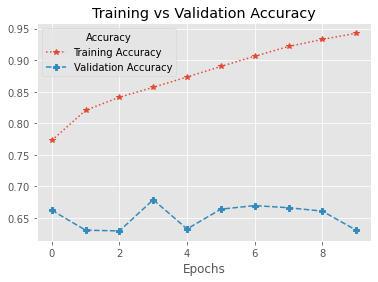

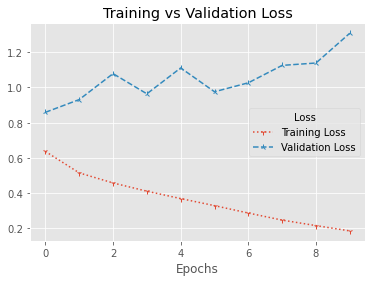

In [77]:
# plot the model performance....
plot_model_performance(history_5)

In [78]:
# Almost all our previous models overfitts the data. So let's try another approach.

# Model 6 : Pretrained Embeddings Transfer Learning

In [80]:
# we'll build the transfer learning model by using Universal Sentence Encoder Embedding Layer...

# setup the random seed
tf.random.set_seed(42)

hub_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

# defining sentence encoded layer....
sentence_encod_layer = hub.KerasLayer(hub_url,
                                     input_shape = (),
                                     dtype = "string",
                                     trainable = False,
                                     name = "Universal_Encoded")

# building the model
model_6 = tf.keras.models.Sequential([
    sentence_encod_layer,
    layers.Dense(64, activation = "relu"),
    layers.Dense(3, activation = "softmax")
], name = "Model_USE")

# compiling the model
model_6.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

2022-10-18 22:56:33.057457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [81]:
# model summary...
model_6.summary()

Model: "Model_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Universal_Encoded (KerasLay  (None, 512)              256797824 
 er)                                                             
                                                                 
 dense_11 (Dense)            (None, 64)                32832     
                                                                 
 dense_12 (Dense)            (None, 3)                 195       
                                                                 
Total params: 256,830,851
Trainable params: 33,027
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
# fit model to data....
history_6 = model_6.fit(train_text,train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.20))

Epoch 1/10


2022-10-18 22:57:32.413380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.6697

2022-10-18 22:58:05.808208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - 43s 47ms/step - loss: 0.7564 - accuracy: 0.6697 - val_loss: 0.6987 - val_accuracy: 0.6910
Epoch 2/10
859/859 [==============================] - 39s 46ms/step - loss: 0.6923 - accuracy: 0.6953 - val_loss: 0.6882 - val_accuracy: 0.7006
Epoch 3/10
859/859 [==============================] - 38s 44ms/step - loss: 0.6788 - accuracy: 0.7002 - val_loss: 0.6832 - val_accuracy: 0.7063
Epoch 4/10
859/859 [==============================] - 38s 44ms/step - loss: 0.6671 - accuracy: 0.7085 - val_loss: 0.6798 - val_accuracy: 0.7102
Epoch 5/10
859/859 [==============================] - 38s 44ms/step - loss: 0.6565 - accuracy: 0.7127 - val_loss: 0.6791 - val_accuracy: 0.7074
Epoch 6/10
859/859 [==============================] - 38s 44ms/step - loss: 0.6455 - accuracy: 0.7185 - val_loss: 0.6749 - val_accuracy: 0.7071
Epoch 7/10
859/859 [==============================] - 38s 44ms/step - loss: 0.6344 - accuracy: 0.7258 - val_loss: 0.6762 - val_accuracy: 0.7128
Epo

In [83]:
# model predictions and calculate results...
model_6_results = calculate_results(test_labels,tf.squeeze(tf.round(model_6.predict(test_text))))
model_6_results

2022-10-18 23:04:00.912809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 11s 96ms/step


{'Accuracy': 0.6539332201471421,
 'Precision': 0.7519024069744775,
 'Recall': 0.6539332201471421,
 'F_Score': 0.6982329529338487}

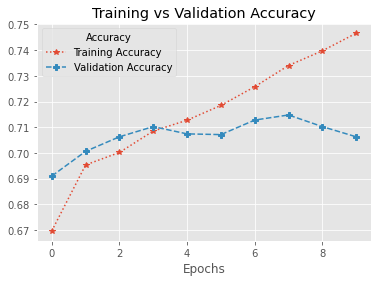

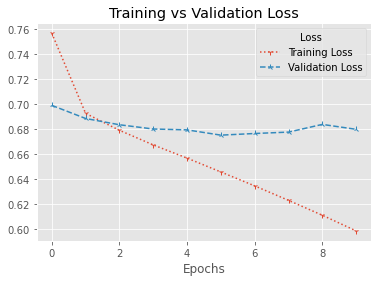

In [84]:
# plot model performance....
plot_model_performance(history_6)

In [85]:
# combine all model results and pick the one that performs better....
model_results = pd.DataFrame({
    "Naive" : model_0_results,
    "Dense" : model_1_results,
    "LSTM" : model_2_results,
    "GRU" : model_3_results,
    "Bidirectional" : model_4_results,
    "Conv1D" : model_5_results,
    "Transfer" : model_6_results
})

model_results = model_results.transpose()
model_results

,Accuracy,Precision,Recall,F_Score
Naive,0.620826,0.692004,0.620826,0.608446
Dense,0.650821,0.737251,0.650821,0.675613
LSTM,0.630164,0.677180,0.630164,0.652726
GRU,0.367855,0.544194,0.824844,0.654821
Bidirectional,0.639785,0.681284,0.639785,0.659755
Conv1D,0.619694,0.690770,0.619694,0.650839
Transfer,0.653933,0.751902,0.653933,0.698233


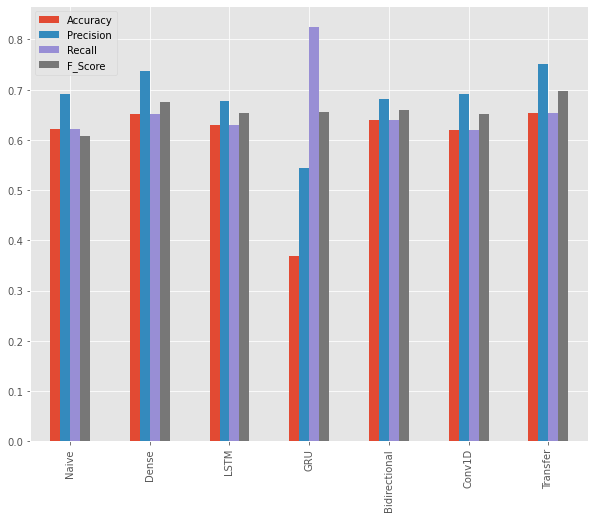

In [86]:
# let's visualize it....
model_results.plot(kind = "bar", figsize = (10,8));

# Dense Model : with more layers...

In [87]:
# let's build our first dense model.....

# set up the random seed....
tf.random.set_seed(42)

# build new embedding layer...
embedd = Embedding(input_dim = max_token,
                  output_dim = 512,
                   input_length = max_len,
                   embeddings_initializer = "uniform",)

# define the inputs....
inputs = layers.Input(shape=(),dtype="string")

# pass inputs to tokenization layer....
x = token(inputs)

# pass the token to embeddings....
x = embedd(x)

# hidden layers...
x = layers.Dense(512,activation="relu")(x)
# adding 2nd layer...
x = layers.Dense(256,activation="relu")(x)
# adding 3rd layer....
x = layers.Dense(128,activation="relu")(x)
# adding 4th layer....
x = layers.Dense(64,activation="relu")(x)
# adding 5th layer....
x = layers.Dense(32,activation="relu")(x)
# adding 6th layer....
x = layers.Dense(16,activation="relu")(x)
# adding the globalaverage layer...
x = layers.GlobalAveragePooling1D()(x)
# adding output layer....
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_7 = tf.keras.Model(inputs,output,name="Dense_Model_1")

# compiling the model...
model_7.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [88]:
# model summary....
model_7.summary()

Model: "Dense_Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 15, 512)           7680000   
                                                                 
 dense_13 (Dense)            (None, 15, 512)           262656    
                                                                 
 dense_14 (Dense)            (None, 15, 256)           131328    
                                                                 
 dense_15 (Dense)            (None, 15, 128)           32896     
                                                     

In [94]:
# fitting model to data....
history_7 = model_7.fit(train_text,train_labels,
                       epochs = 20,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.20))

Epoch 1/20
859/859 [==============================] - 40s 46ms/step - loss: 0.5024 - accuracy: 0.8122 - val_loss: 0.8750 - val_accuracy: 0.6565
Epoch 2/20
859/859 [==============================] - 40s 46ms/step - loss: 0.4922 - accuracy: 0.8142 - val_loss: 0.9759 - val_accuracy: 0.6259
Epoch 3/20
859/859 [==============================] - 40s 46ms/step - loss: 0.4801 - accuracy: 0.8193 - val_loss: 0.9397 - val_accuracy: 0.6406
Epoch 4/20
859/859 [==============================] - 39s 45ms/step - loss: 0.4784 - accuracy: 0.8198 - val_loss: 0.9391 - val_accuracy: 0.6531
Epoch 5/20
859/859 [==============================] - 39s 45ms/step - loss: 0.4692 - accuracy: 0.8253 - val_loss: 0.9319 - val_accuracy: 0.6474
Epoch 6/20
859/859 [==============================] - 39s 45ms/step - loss: 0.4659 - accuracy: 0.8258 - val_loss: 0.9789 - val_accuracy: 0.6449
Epoch 7/20
859/859 [==============================] - 38s 45ms/step - loss: 0.4627 - accuracy: 0.8272 - val_loss: 0.9466 - val_accuracy:

In [95]:
# calculate results.....
model_7_results = calculate_results(test_labels, tf.squeeze(tf.round(model_7.predict(test_text))))
model_7_results

111/111 [==============================] - 1s 11ms/step


{'Accuracy': 0.6205432937181664,
 'Precision': 0.661296009821554,
 'Recall': 0.6205432937181664,
 'F_Score': 0.6399277669744918}

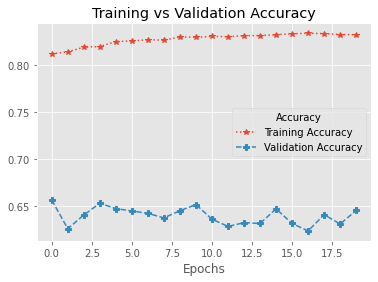

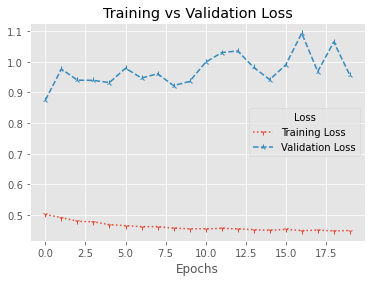

In [96]:
plot_model_performance(history_7)